# Introduction

This dataset was scraped from [nextspaceflight.com](https://nextspaceflight.com/launches/past/?page=1) and includes all the space missions since the beginning of Space Race between the USA and the Soviet Union in 1957.

### Import Statements

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from IPython.core.display import HTML
import iso3166
import phik
import imageio

### Notebook Presentation

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

### Load the Data

In [3]:
df_data = pd.read_csv('mission_launches.csv')

## Preliminary Data Exploration


In [4]:
df_data.shape

(4324, 9)

In [5]:
df_data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Organisation', 'Location', 'Date',
       'Detail', 'Rocket_Status', 'Price', 'Mission_Status'],
      dtype='object')

In [6]:
df_data.head(2)

Unnamed: 0.1  Unnamed: 0 Organisation  \
0             0           0       SpaceX   
1             1           1         CASC   

                                            Location  \
0         LC-39A, Kennedy Space Center, Florida, USA   
1  Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...   

                         Date                                        Detail  \
0  Fri Aug 07, 2020 05:12 UTC  Falcon 9 Block 5 | Starlink V1 L9 & BlackSky   
1  Thu Aug 06, 2020 04:01 UTC           Long March 2D | Gaofen-9 04 & Q-SAT   

  Rocket_Status  Price Mission_Status  
0  StatusActive   50.0        Success  
1  StatusActive  29.75        Success

In [7]:
df_data.tail(2)

Unnamed: 0.1  Unnamed: 0 Organisation  \
4322          4322        4322    RVSN USSR   
4323          4323        4323    RVSN USSR   

                                       Location                        Date  \
4322  Site 1/5, Baikonur Cosmodrome, Kazakhstan  Sun Nov 03, 1957 02:30 UTC   
4323  Site 1/5, Baikonur Cosmodrome, Kazakhstan  Fri Oct 04, 1957 19:28 UTC   

                          Detail  Rocket_Status Price Mission_Status  
4322  Sputnik 8K71PS | Sputnik-2  StatusRetired   NaN        Success  
4323  Sputnik 8K71PS | Sputnik-1  StatusRetired   NaN        Success

In [8]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4324 entries, 0 to 4323
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0.1    4324 non-null   int64 
 1   Unnamed: 0      4324 non-null   int64 
 2   Organisation    4324 non-null   object
 3   Location        4324 non-null   object
 4   Date            4324 non-null   object
 5   Detail          4324 non-null   object
 6   Rocket_Status   4324 non-null   object
 7   Price           964 non-null    object
 8   Mission_Status  4324 non-null   object
dtypes: int64(2), object(7)
memory usage: 304.2+ KB


## Data Cleaning - Check for Missing Values and Duplicates

Consider removing columns containing junk data. 

In [9]:
df_data.isna().sum()

Unnamed: 0.1         0
Unnamed: 0           0
Organisation         0
Location             0
Date                 0
Detail               0
Rocket_Status        0
Price             3360
Mission_Status       0
dtype: int64

In [10]:
df_data.duplicated(keep=False).values.any()

np.False_

In [11]:
col_subset = ['Organisation','Location', 'Date', 'Rocket_Status', 'Price', 'Mission_Status']
clean_df = df_data.copy()[col_subset]

In [12]:
# Extract Country from Launch Location
separated_values = clean_df.Location.str.split(',')
clean_df["Country"] = separated_values.str[-1].str.strip() 

In [13]:
# Turn Date values to datetime64 format
clean_df['Date'] = pd.to_datetime(clean_df['Date'], errors='coerce', format='mixed', utc=True)
clean_df['Date'] = clean_df['Date'].dt.normalize()
# Remove timezone information and keep only the date
clean_df['Date'] = clean_df['Date'].dt.tz_localize(None)

In [14]:
# Change Price column to numeric
clean_df["Price"] = pd.to_numeric(clean_df["Price"], errors='coerce')

In [15]:
print(clean_df.dtypes)

Organisation              object
Location                  object
Date              datetime64[ns]
Rocket_Status             object
Price                    float64
Mission_Status            object
Country                   object
dtype: object


In [16]:
# Extract the year from the 'Date' column for future year by year analysis
clean_df['Year'] = clean_df['Date'].dt.year

## Descriptive Statistics

In [17]:
clean_df[['Date', 'Price']].describe()

Date  Price
count                           4324 949.00
mean   1987-11-28 05:24:01.998149824 129.80
min              1957-10-04 00:00:00   5.30
25%              1972-04-19 18:00:00  40.00
50%              1984-12-16 12:00:00  62.00
75%              2002-09-10 12:00:00 164.00
max              2020-08-07 00:00:00 450.00
std                              NaN 143.22

**The dataset covers a wide range of dates from 1957 to 2020. The Price column has significant variation, as indicated by the large standard deviation compared to the mean price per launch. This suggests that the prices in the dataset are spread out over a wide range.**

In [18]:
clean_df.columns


Index(['Organisation', 'Location', 'Date', 'Rocket_Status', 'Price',
       'Mission_Status', 'Country', 'Year'],
      dtype='object')

In [19]:
clean_df[['Organisation', 'Location','Rocket_Status', 'Mission_Status']].describe()

Organisation                                    Location  \
count          4324                                        4324   
unique           56                                         137   
top       RVSN USSR  Site 31/6, Baikonur Cosmodrome, Kazakhstan   
freq           1777                                         235   

        Rocket_Status Mission_Status  
count            4324           4324  
unique              2              4  
top     StatusRetired        Success  
freq             3534           3879

- **The dataset is dominated by missions from "RVSN USSR," showing that it had significant involvement in space launches.**
- **The most frequent launch site is "Baikonur Cosmodrome," which has been pivotal in space missions, particularly for Soviet and Russian space agencies.**
- **The majority of the rockets in the dataset are retired, which suggests many historical missions or that rockets are not typically reused.**
- **The vast majority of missions (3879 out of 4324) have been successful, indicating a high success rate in the missions included in this dataset.**

In [20]:
# Correlation between different parameters
interval_cols = ['Price', 'Date']
correlation_matrix=clean_df[['Organisation', 'Location', 'Year', 'Rocket_Status', 'Price',
             'Mission_Status']].phik_matrix(interval_cols=interval_cols)

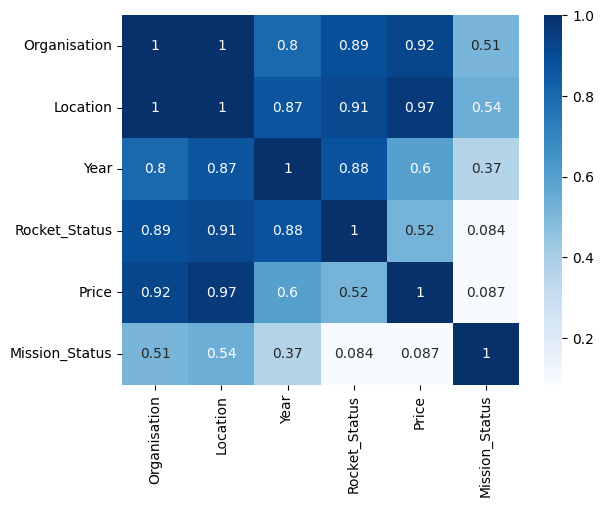

In [21]:
correlation_map = sns.heatmap(correlation_matrix, cmap="Blues", annot=True)
plt.show()

In [22]:
%%html
<div>
    <img src="assets/correlation_map.png"/>
</div>

**The dataset spans from 1957 to 2020, offering a comprehensive historical perspective on space missions over six decades. The Price column exhibits substantial variability, as evidenced by the large standard deviation relative to the mean, indicating a wide range of costs associated with these missions.**

**Several notable correlations emerge from the analysis:**

- *Price and Location:* A very high correlation (0.97) between Price and Location suggests that the cost of missions is highly dependent on the launch location. This could reflect varying logistical costs, regulatory environments, or regional economic factors impacting mission expenses.

- *Rocket Status and Launch Location Country:* The moderate to strong correlation (0.74) between Rocket_Status and Launch_Location_Country indicates that the success or operational status of rockets is influenced by the country from which they are launched. This could be due to differences in technology, infrastructure, or regulatory standards across countries.

- *Rocket Status and Location:* A strong correlation (0.91) between Rocket_Status and Location further underscores the significance of geographical factors, suggesting that specific launch sites may have better infrastructure or more advanced technology, influencing rocket performance.

- *Temporal and Location-Based Factors:* The correlations between Year and Location (0.86) and Rocket_Status and Year (0.9) suggest that both the choice of launch location and rocket performance have evolved over time. This could reflect advancements in technology, changes in international collaboration, or shifts in strategic priorities in space exploration.

**Overall, the data reveals that both geographical and temporal factors significantly impact the costs and outcomes of space missions, highlighting the complex interplay between location, time, and mission success.**



### Number of Launches per Company

In [23]:
top15_comp = clean_df.Organisation.value_counts()[:15]
top15_comp = top15_comp.index.unique()

In [24]:
plt.style.use('seaborn-v0_8-white')

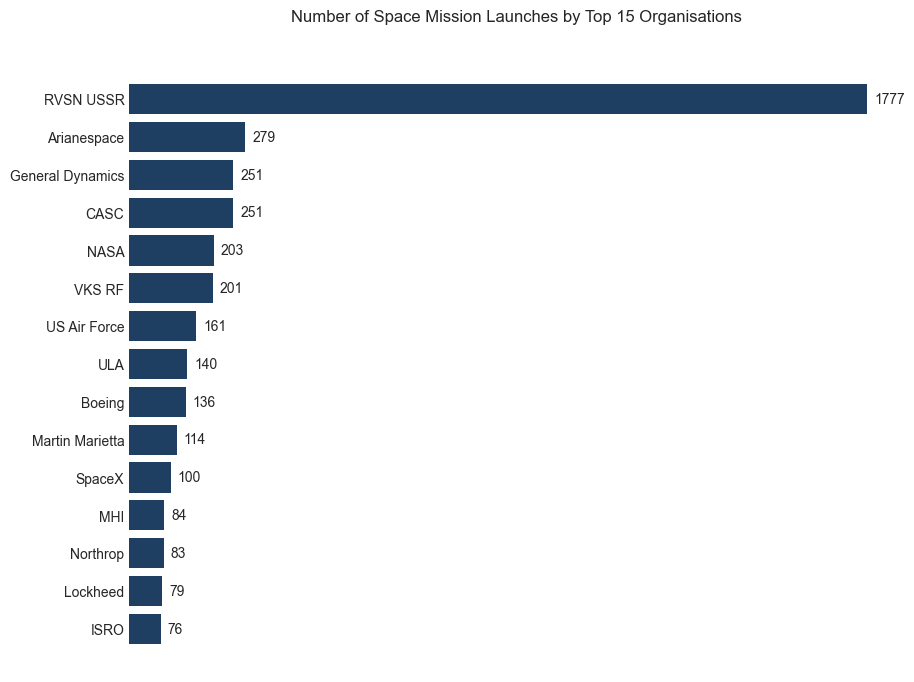

In [25]:
# number of space mission launches by organisation
org_counts = clean_df.loc[(clean_df.Organisation.isin(top15_comp))].Organisation.value_counts().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.barh(org_counts.index, org_counts.values, color='#1E3E62', edgecolor='#091057' , height=0.8, linewidth=0)
ax.bar_label(bars, label_type='edge', padding=5)
ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
ax.xaxis.set_visible(False)
plt.title('Number of Space Mission Launches by Top 15 Organisations', pad=25)
plt.show()

### Timeline of Space Missions by Organization and Mission Count

In [26]:
# Calculate the count of Mission_Status and the start and end years for each Organisation
dist_over_time = clean_df.groupby(['Organisation'], as_index=False).agg({
    'Mission_Status': 'count',  
    'Date': ['min', 'max']      
})
dist_over_time.columns = ['Organisation', 'Mission_Count', 'Start_Year', 'End_Year']
dist_over_time = dist_over_time.sort_values('Mission_Count', ascending=False)[:40].sort_values('Start_Year')

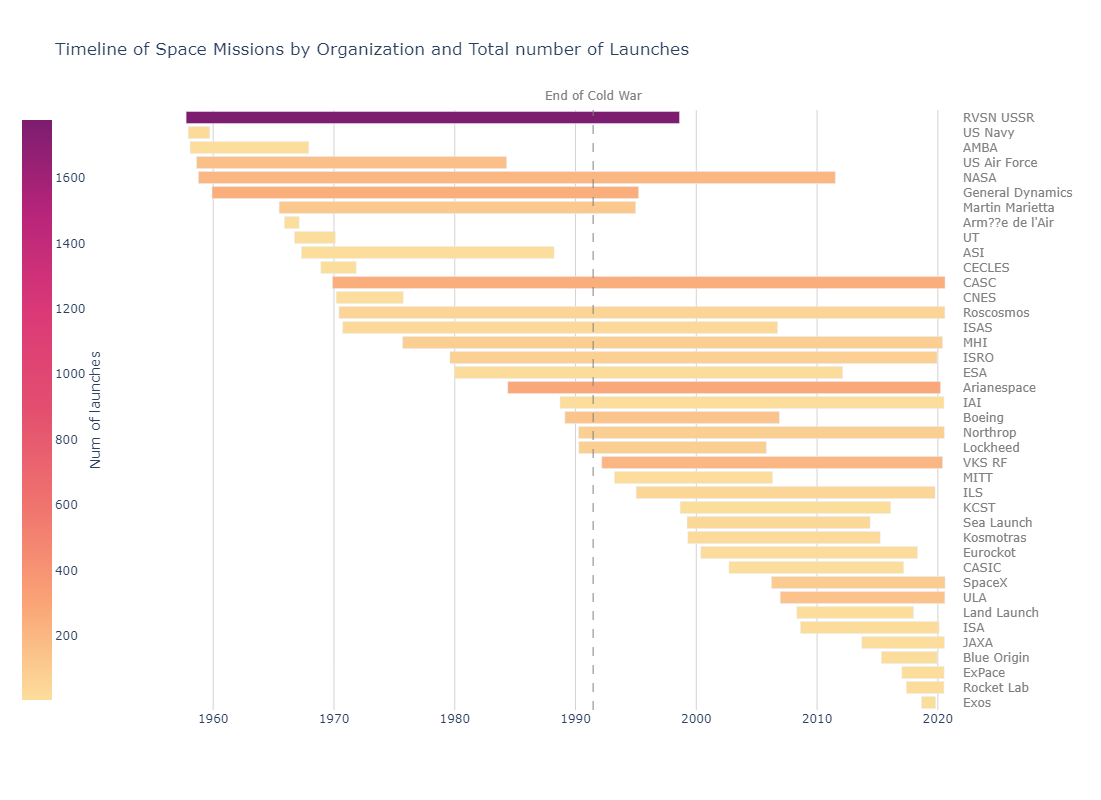

In [27]:
org_timeline = px.timeline(dist_over_time, x_start="Start_Year", x_end="End_Year", y="Organisation", 
                           color="Mission_Count", 
                           color_continuous_scale="sunsetdark",
                           title= "Timeline of Space Missions by Organization and Total number of Launches",
                           )
org_timeline.update_yaxes(visible=True, autorange="reversed", title="", color='grey', side='right')
org_timeline.update_xaxes(range=['1957', '2022'], visible=True, showgrid=True, gridcolor='lightgrey', tickwidth=1)
org_timeline.update_layout(height=800, width=1100, plot_bgcolor='white', paper_bgcolor='white', 
                           margin_l=60, margin_r=60, margin_t=110, margin_b=90, 
                           coloraxis_colorbar_xanchor="left",  coloraxis_colorbar_x=-0.21, coloraxis_colorbar_title="Num of launches",
                           coloraxis_colorbar_title_side='right', coloraxis_colorbar_len=1)
org_timeline.update_traces(textposition='outside') 
org_timeline.add_vline(x='1991-06-17', line_width=1, line_dash="dash", line_color="grey")  
org_timeline.add_annotation(
    x='1991-06-17',           
    y=1.025,                      
    text="End of Cold War",   
    showarrow=False,         
    xref="x",              
    yref="paper",             
    xanchor="center",        
    yanchor="middle",            
    font_color='grey'
)

org_timeline.show()

In [28]:
%%html
<div>
    <img src="assets/org_timeline.png"/>
</div>

**The timeline illustrates the evolution of space missions across various international organizations**

- The RVSN USSR has the longest active period and the highest number of missions, reflecting its central role in Soviet space exploration during the Cold War. Since no private space companies existed in the USSR at that time, all launches were conducted by this single organization, accounting for its large mission volume.

- In contrast, multiple U.S. organizations were active by the end of the Cold War, making it more appropriate to compare launches between countries rather than individual organizations.

-  Post-Cold War, with industrial advancements, many new space organizations emerged globally, with more than half of current entities founded during this period.


### Number of Active versus Retired Rockets

How many rockets are active compared to those that are decomissioned? 

In [29]:
rocket_status = clean_df.Rocket_Status.value_counts()

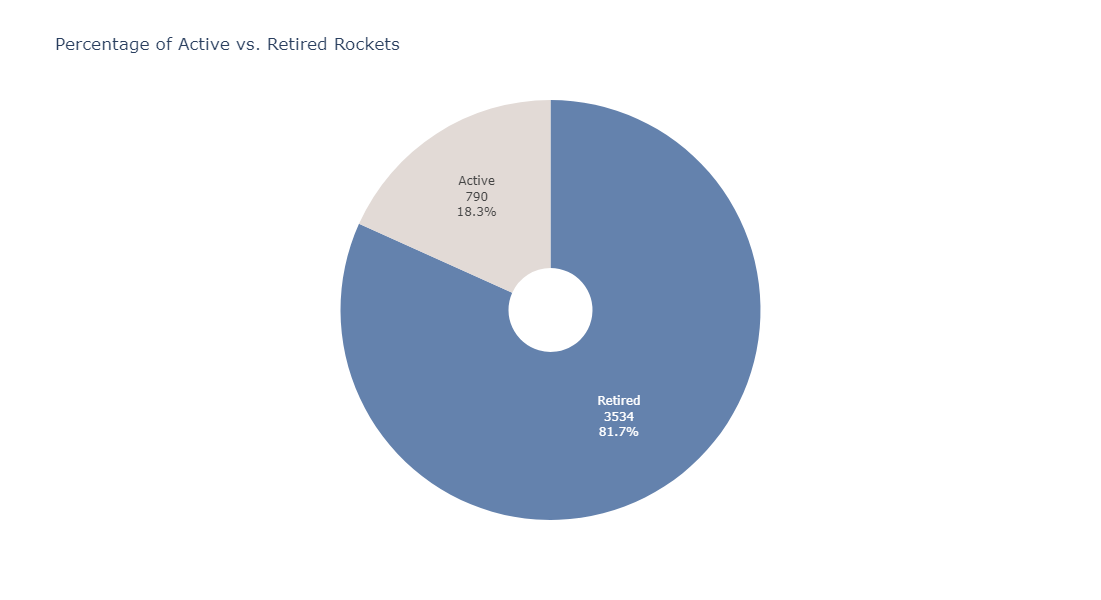

In [30]:
color_map_status = {
    'StatusRetired': '#6482AD',
    'StatusActive': '#E2DAD6'
}

rocket_status = px.pie(
    values=rocket_status.values,
    title='Percentage of Active vs. Retired Rockets',
    hole=0.2,
    names= ["Retired", "Active"],
    color = rocket_status.index,
    color_discrete_map=color_map_status,
    width=600,  
    height=600   
)

rocket_status.update_traces(
    textinfo='label+percent+value', 
    textposition='inside'
)


rocket_status.update_layout(
    uniformtext_minsize=14,
    showlegend=False)

rocket_status.show()

In [31]:
%%html
<div>
    <img src="assets/rocket_status.png"/>
</div>

### Distribution of Mission Status

How many missions were successful?
How many missions failed?

In [32]:
mission_status = clean_df.Mission_Status.value_counts()

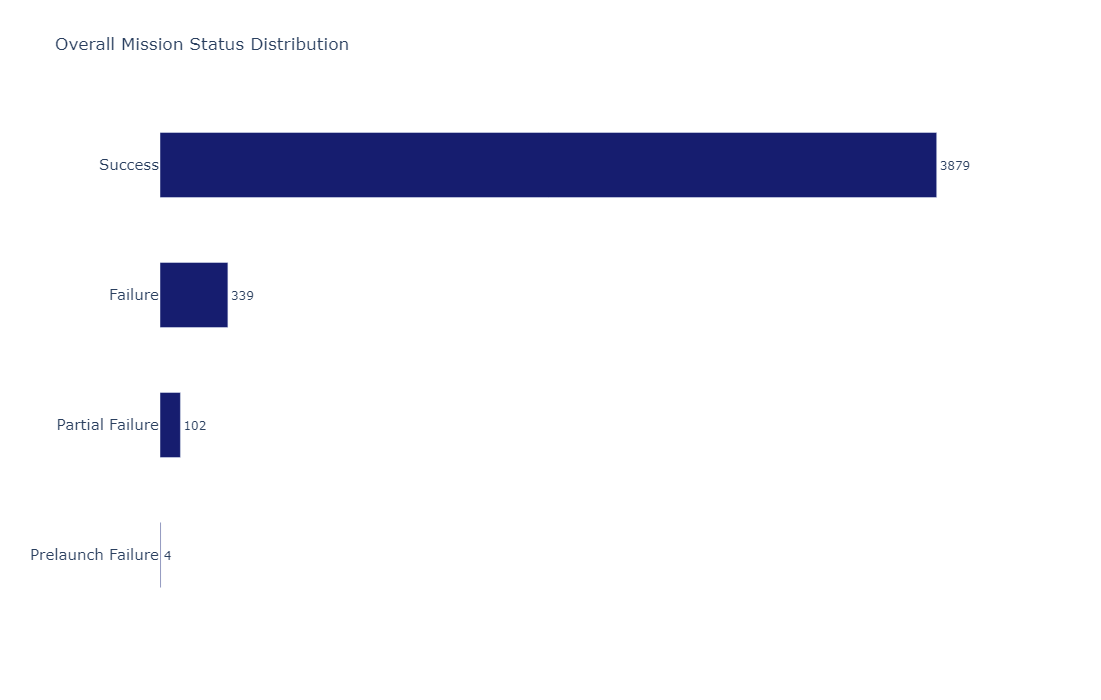

In [33]:
mission_status_distr = px.bar(  y = mission_status.index,
                                x = mission_status.values,
                                title="Overall Mission Status Distribution",
                                height= 700,
                                width = 1000,
                                text=mission_status.values,
                                orientation='h',
                                )

mission_status_distr.update_layout(yaxis_title='',
                                   xaxis_title='Number of Missions',
                                   bargap=0.5,
                                   showlegend=False,
                                   # height=700, 
                                   # width=1000, 
                                   plot_bgcolor='white', 
                                   paper_bgcolor='white')

# Update trace to show text on bars
mission_status_distr.update_traces(textposition='outside', marker_color='#161D6F')
mission_status_distr.update_xaxes(range=[0, 4300], visible=False)
mission_status_distr.update_yaxes(visible=True, showgrid=True, autorange="reversed", tickfont_size=15)

mission_status_distr.show()

In [34]:
mission_status.sum()

np.int64(4324)

In [35]:
%%html
<div>
    <img src="assets/mission_status_distr.png"/>
</div>

In [36]:
print(f'Mission Success Rate: {round(mission_status["Success"]/mission_status.sum()*100, 2)}%')

Mission Success Rate: 89.71%


### How Expensive are the Launches? 

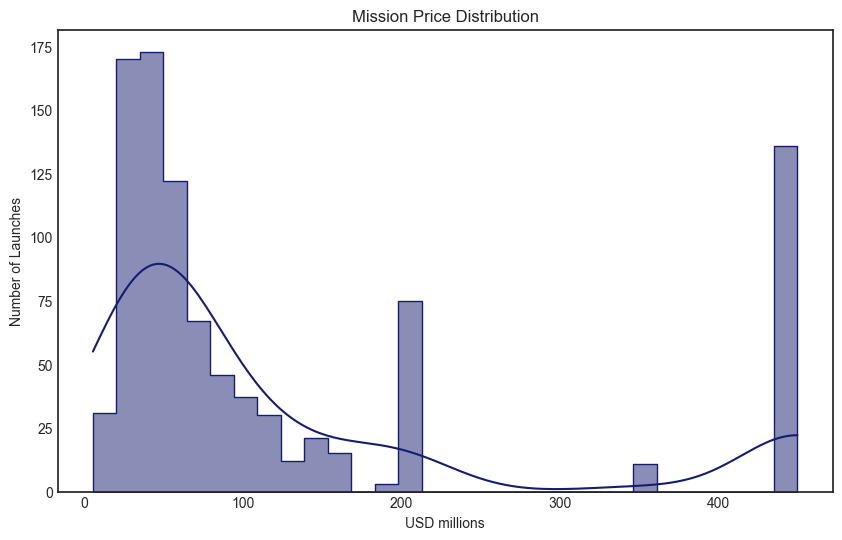

In [37]:
price_distr = sns.histplot(clean_df['Price'], 
                           stat='count', 
                           kde=True, 
                           fill=True, 
                           cumulative=False, 
                           bins=40,
                           binwidth=15, 
                           element="step", 
                           color='#161D6F')
plt.title('Mission Price Distribution')
plt.xlabel("USD millions")
plt.ylabel("Number of Launches")
plt.gcf().set_size_inches(10, 6)

In [38]:
clean_df['Price'].describe()

count   949.00
mean    129.80
std     143.22
min       5.30
25%      40.00
50%      62.00
75%     164.00
max     450.00
Name: Price, dtype: float64

In [39]:
median = clean_df['Price'].median()
print(f'Median of Price: {median}' )

Median of Price: 62.0


In [40]:
skewness = clean_df['Price'].skew()
print(f'Skewness of Price: {skewness}. Skewness > 0: Right-skewed' )

Skewness of Price: 1.5077937711635496. Skewness > 0: Right-skewed


In [41]:
# Let's Identify Outlier Companies in the Dataset (Launch Costs Exceeding $200 Million)
outlier_org = clean_df[clean_df['Price'] > 200]['Organisation'].unique()
print(f"{outlier_org}")

['ULA' 'NASA' 'Boeing']


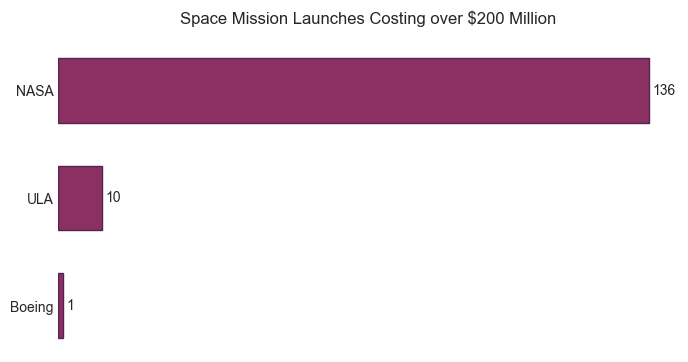

In [94]:
# Count organisations with prices exceeding $200 million
outlier_org = clean_df[clean_df['Price'] > 200]['Organisation'].value_counts().sort_values()

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.barh(outlier_org.index, outlier_org.values , color='#8C3061', edgecolor='#522258' , height=0.6, linewidth=1)
ax.bar_label(bars, label_type='edge', padding=3)
ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
ax.xaxis.set_visible(False)
plt.title('Space Mission Launches Costing over $200 Million', pad=15)
plt.show()

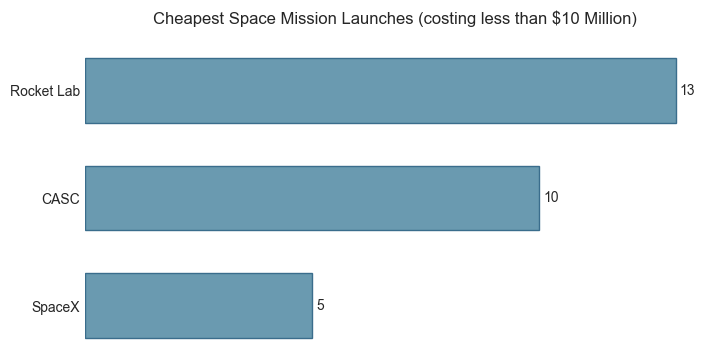

In [95]:
# Count organisations with the lowest prices
outlier_org = clean_df[clean_df['Price'] < 10]['Organisation'].value_counts().sort_values()

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.barh(outlier_org.index, outlier_org.values , color='#6A9AB0', edgecolor='#3A6D8C' , height=0.6, linewidth=1)
ax.bar_label(bars, label_type='edge', padding=3)
ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
ax.xaxis.set_visible(False)
plt.title('Cheapest Space Mission Launches (costing less than $10 Million)', pad=15)
plt.show()

## Number of Launches by Launch Site

In [44]:
df_launch_loc = pd.read_csv('df_launch_sites.csv')

In [45]:
subset_1 = clean_df[['Location', 'Mission_Status', 'Rocket_Status', 'Price', 'Year']]
subset_2 = df_launch_loc[['Location', 'Latitude', 'Longitude', 'Space_Center_Name']]
merged_df = pd.merge(subset_1, subset_2, on="Location", how="outer")

In [46]:
grouped_df = merged_df.groupby(['Space_Center_Name', 'Latitude', 'Longitude', 'Year']).agg({'Mission_Status': 'count'}).reset_index()
grouped_df = grouped_df.sort_values(['Space_Center_Name', 'Latitude', 'Longitude', 'Year'])
grouped_df['Cumulative_Num_Launches'] = grouped_df.groupby(['Space_Center_Name', 'Latitude', 'Longitude'])['Mission_Status'].cumsum()
grouped_df = grouped_df.sort_values("Year")

In [47]:
# Calculate the cumulative sum Launthes for graph

all_years = pd.DataFrame({'Year': range(merged_df['Year'].min(), merged_df['Year'].max() + 1)})
space_centers = merged_df[['Space_Center_Name', 'Latitude', 'Longitude']].drop_duplicates()
all_combinations = pd.merge(space_centers.assign(key=1), all_years.assign(key=1), on='key').drop('key', axis=1)

full_df = pd.merge(all_combinations, grouped_df, on=['Space_Center_Name', 'Latitude', 'Longitude', 'Year'], how='left')
full_df['Mission_Status'] = full_df['Mission_Status'].fillna(0)
full_df = full_df.sort_values(['Space_Center_Name', 'Latitude', 'Longitude', 'Year'])
full_df['Cumulative_Num_Launches'] = full_df.groupby(['Space_Center_Name', 'Latitude', 'Longitude'])['Mission_Status'].cumsum()

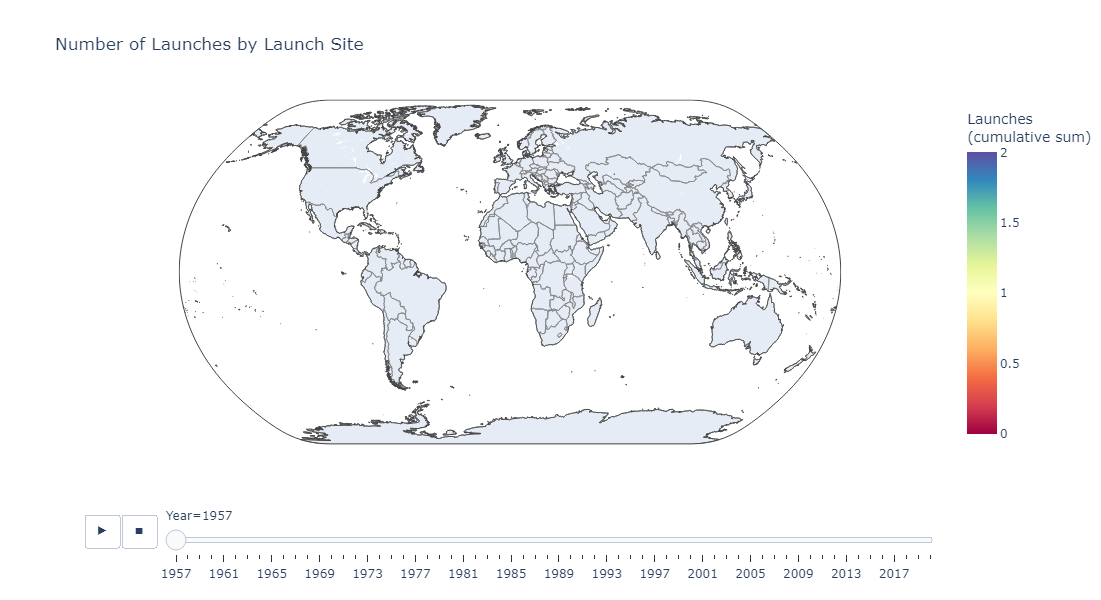

In [98]:
launch_sites = px.scatter_geo(full_df, lat="Latitude", lon="Longitude", color="Cumulative_Num_Launches",
                             color_continuous_scale='spectral', 
                             size_max=50, 
                             projection="natural earth", 
                             height=600,
                             hover_name='Space_Center_Name',
                             hover_data= ['Cumulative_Num_Launches', 'Year'],
                             size="Cumulative_Num_Launches",
                             opacity=0.8,
                             #text='Truncated_Name',
                             animation_group='Year',
                             animation_frame='Year',
                             title="Number of Launches by Launch Site",
                             labels = {'Latitude': '', 'Longitude': '', 'Cumulative_Num_Launches':'Launches<br>(cumulative sum)<br>', 
                                       'Space_Center_Name':'Launch Site', 'Truncated_Name':'', 'Year': 'Year'},
                             #symbol= 'Space_Center_Name'
                              
)

launch_sites.update_traces(textposition='top left', textfont_size=10)
launch_sites.update_geos(visible=True, resolution=50, showcountries=True, countrycolor="Grey")
launch_sites.show()

In [49]:
%%html
<div>
    <img src="assets/launch_sites.png"/>
</div>

## Number of Launches by Country of Launch Site

In [50]:
# Check out the diversity of countries

country_counts = clean_df['Country'].value_counts()
print(country_counts)

Country
Russia                            1395
USA                               1344
Kazakhstan                         701
France                             303
China                              268
Japan                              126
India                               76
Pacific Ocean                       36
Iran                                13
New Zealand                         13
Israel                              11
Kenya                                9
Australia                            6
North Korea                          5
New Mexico                           4
Barents Sea                          3
Brazil                               3
South Korea                          3
Gran Canaria                         2
Shahrud Missile Test Site            1
Yellow Sea                           1
Pacific Missile Range Facility       1
Name: count, dtype: int64


**In the previously generated list of countries (extracted from the Location column), we observe entries such as:**

- Pacific Missile Range Facility
- Yellow Sea
- Shahrud Missile Test Site

**These locations are rocket launch sites associated with countries like the United States, China, and others.**

**Additionally, some country names, such as Russia, may not be universally recognized by their common names, so it's essential to use their official designations, like the Russian Federation.**

In [51]:
# Change some country names to match the system (to find the correct three letter country code) 
# and according logic (depending on which country used which test site):

dict = {'Russia': 'Russian Federation', 
        'New Mexico': 'USA', 
        'Yellow Sea': 'China', 
        'Shahrud Missile Test Site': 'Iran', 
        'Pacific Missile Range Facility': 'USA', 
        'Barents Sea': 'Russian Federation', 
        'Gran Canaria': 'USA'}

for key, value in dict.items():    
    clean_df['Country'] = np.where(clean_df['Country'] == key, value, clean_df['Country'])


country_counts = clean_df['Country'].value_counts()

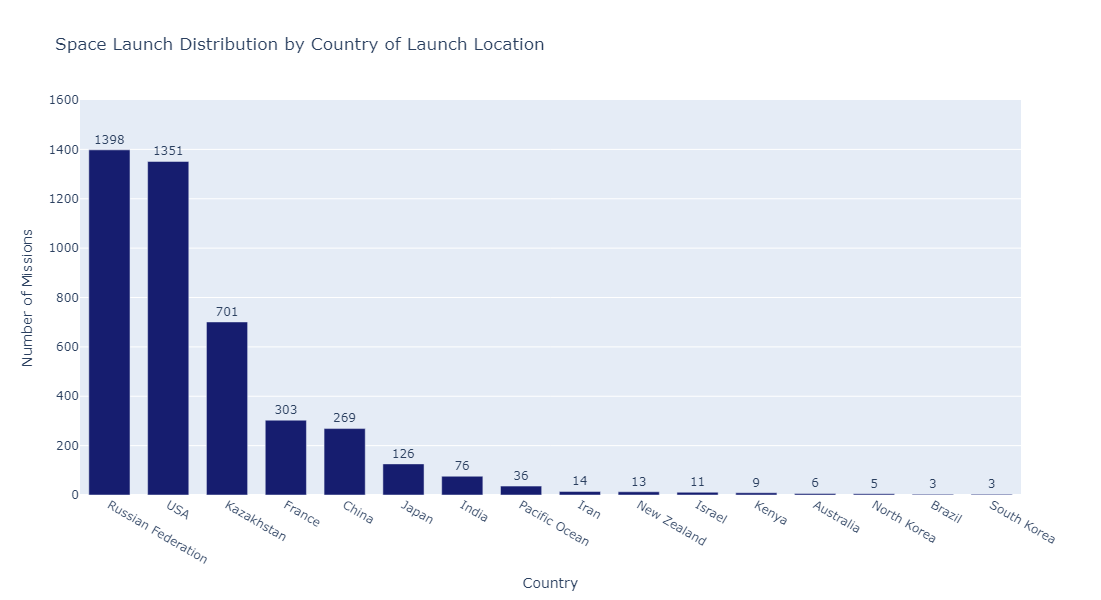

In [52]:
launch_country_launches = px.bar(
        x = country_counts.index,
        y = country_counts.values,
        color = country_counts.values,
        color_continuous_scale="Purp",
        title="Space Launch Distribution by Country of Launch Location",
        height=600,
        text=country_counts.values)

launch_country_launches.update_layout(xaxis_title='Country',
                    coloraxis_showscale=False,
                    yaxis_title='Number of Missions',
                    bargap=0.3,
                    showlegend=False)

# Update trace to show text on bars
launch_country_launches.update_traces(textposition='outside', marker_color='#161D6F')
launch_country_launches.update_yaxes(range=[0, 1600])

launch_country_launches.show()

In [53]:
%%html
<div>
    <img src="assets/launch_country_launches.png"/>
</div>

- Upon closer examination of the resulting list, **Kazakhstan** ranks **third** in the number of rocket launches.

- Kazakhstan is a **relatively young nation**, having gained independence just over 30 years ago after being a part of the Soviet Union as one of its republics. 

- The renowned **Baikonur Cosmodrome**, now situated in Kazakhstan, played a significant role in these launches. 

- This raises the question: **can all these rocket launches be attributed to Kazakhstan?** 

- To address this, let's **examine the organizations responsible for these launches** from this location.

In [54]:
# Let's check more precisely Baikonur Cosmodrome site in Kazakhstan (former republic of the USSR)

clean_df[clean_df.Country == 'Kazakhstan']['Organisation'].unique()

array(['Roscosmos', 'Arianespace', 'ILS', 'VKS RF', 'Land Launch',
       'Kosmotras', 'Starsem', 'RVSN USSR', 'Yuzhmash', 'OKB-586'],
      dtype=object)

**We observe that five organizations have used this location for rocket launches, each belonging to different countries:**

- **VKS RF**, **Roscosmos**, **RVSN USSR**, **Yuzhmash** - Russian Federation
- **Kosmotras** - a joint project between Russia, Ukraine, and Kazakhstan
- **Arianespace** - a French company
- **International Launch Services** (ILS) - USA

**Therefore, we cannot attribute rocket launch locations solely to the country where the launch occurs.**

**In future analyses of countries responsible for organizing rocket launches, it would be more logical to focus on the organization responsible for the launch and the country to which it belongs.**

## Space Launches by Country of Launch Organization

In [55]:
clean_df['Organisation'].unique()

array(['SpaceX', 'CASC', 'Roscosmos', 'ULA', 'JAXA', 'Northrop', 'ExPace',
       'IAI', 'Rocket Lab', 'Virgin Orbit', 'VKS RF', 'MHI', 'IRGC',
       'Arianespace', 'ISA', 'Blue Origin', 'ISRO', 'Exos', 'ILS',
       'i-Space', 'OneSpace', 'Landspace', 'Eurockot', 'Land Launch',
       'CASIC', 'KCST', 'Sandia', 'Kosmotras', 'Khrunichev', 'Sea Launch',
       'KARI', 'ESA', 'NASA', 'Boeing', 'ISAS', 'SRC', 'MITT', 'Lockheed',
       'AEB', 'Starsem', 'RVSN USSR', 'EER', 'General Dynamics',
       'Martin Marietta', 'Yuzhmash', 'Douglas', 'ASI', 'US Air Force',
       'CNES', 'CECLES', 'RAE', 'UT', 'OKB-586', 'AMBA',
       "Arm??e de l'Air", 'US Navy'], dtype=object)

In [56]:
print(f"Total number of organisations - {clean_df['Organisation'].nunique()}")

Total number of organisations - 56


**Let's create a dictionary that maps each organization to its corresponding country, and then update the values in the Country column of our DataFrame based on this dictionary.**

In [57]:
launch_country = {"RVSN USSR": "Russian Federation", "Arianespace": "France", "CASC" : "China", "General Dynamics" : "USA",
                       "NASA": "USA", "VKS RF" : "Russian Federation", "US Air Force": "USA", "ULA": "USA", "Boeing": "USA", "Martin Marietta": "USA",
                       "SpaceX": "USA", "MHI": "Japan", "Northrop" : "USA", "Lockheed" : "USA", "ISRO": "India", "Roscosmos": "Russian Federation", 
                       "ILS":["Russian Federation", "USA"], "Sea Launch": ["Norway","Russian Federation", "Ukraine", "USA"], "ISAS": "Japan", 
                       "Kosmotras": ["Russian Federation", "Ukraine", "Kazakhstan"], "US Navy": "USA", "ISA":"Iran", "Rocket Lab" : "USA", 
                       "Eurockot": ["Russian Federation", "Germany"], "ESA" : "European Union", "Blue Origin": "USA", "IAI" : "Israel", "ExPace": "China", 
                       "ASI": "Italy", "CNES": "France", "AMBA": "United Kingdom", "MITT": "Russian Federation", "JAXA": "Japan", 
                       "Land Launch" : ["Russian Federation", "Ukraine"], "UT": "USA", "KCST" : "North Korea", "CASIC": "China", "Exos": "USA", 
                       "CECLES": "France", "Arm??e de l'Air": "France", "KARI": "South Korea", "SRC": "Russian Federation", "AEB": "Brazil", 
                       "RAE": "United Kingdom", "OKB-586": "Russian Federation", "Yuzhmash": "Russian Federation", "Landspace": "China",
                       "Douglas": "USA", "EER": "USA", "Starsem": ["Russian Federation", "France"], "Virgin Orbit": "USA", "IRGC": "Iran", 
                       "i-Space": "China", "OneSpace":"China", "Sandia": "USA", "Khrunichev": "Russian Federation"}

In [58]:
clean_df.rename(columns={'Country': 'Launch_Location_Country'}, inplace=True)

def get_country_string(org):
    countries = launch_country.get(org, [])
    if isinstance(countries, list):
        return ', '.join(countries)
    elif isinstance(countries, str):
        return countries
    return ''

def set_launch_type(org_country):
    if ',' in org_country:
        return 'International'
    elif "European Union" in org_country:
        return 'International'
    else:
        return 'National'

clean_df['Organization_Country'] = clean_df['Organisation'].apply(get_country_string)
clean_df['Launch_Type'] = clean_df['Organization_Country'].apply(lambda x: set_launch_type(x))
organisation_related_country = clean_df['Organization_Country'].value_counts()

In [59]:
# Convert 'Organization_Country' to ISO3 codes only for national launches

def get_alpha3_code(country_name):
    if country_name == "Iran":
        country_name ='Iran, Islamic Republic of'
    elif country_name == "North Korea":
        country_name = "Korea, Democratic People's Republic of"
    elif country_name == "South Korea":
        country_name = 'Korea, Republic of'
    elif country_name == "United Kingdom":
        country_name = 'United Kingdom of Great Britain and Northern Ireland'
        
    country_name = country_name.upper()

    for value in iso3166.countries_by_name.values():
        if value.name.upper() == country_name:
            return value.alpha3
        elif value.alpha3 == country_name:
            return country_name
        elif value.apolitical_name.upper() == country_name:
            return value.alpha3
    
    # If no match is found
    return None  

In [60]:
# Filter the DataFrame for national launches and ensure it's a copy
single_nation_launch = clean_df[clean_df['Launch_Type'] == 'National'].copy()

In [61]:
clean_df['ISO_launch_country'] =  clean_df['Launch_Location_Country'].apply(get_alpha3_code)

In [62]:
clean_df['ISO_org_country'] = clean_df['Organization_Country'].apply(get_alpha3_code)

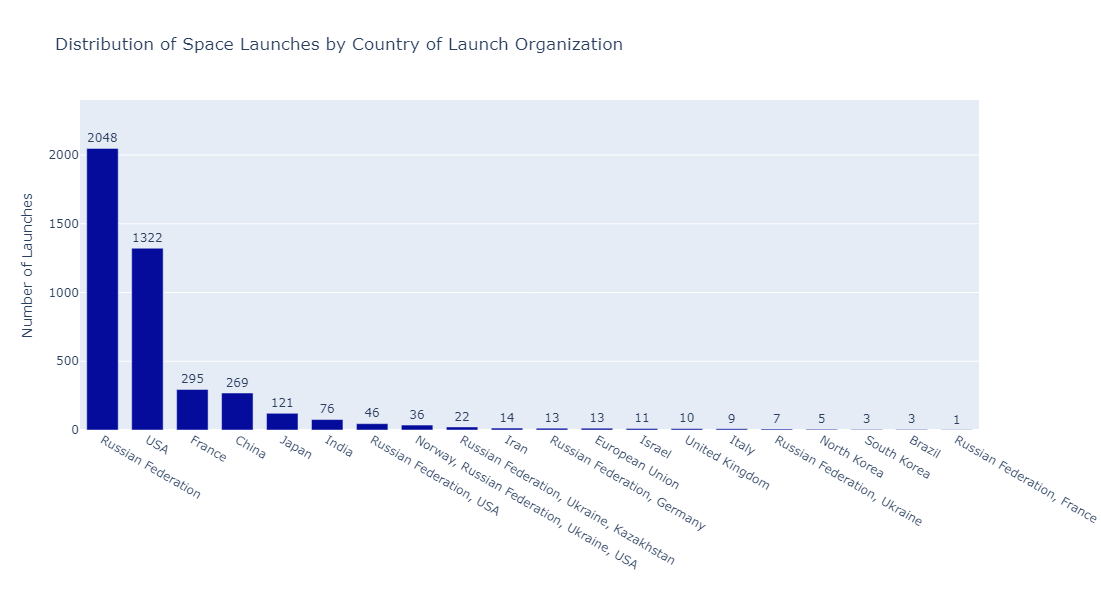

In [100]:
country_org_launch = px.bar(
        x = organisation_related_country.index,
        y = organisation_related_country.values,
        title="Distribution of Space Launches by Country of Launch Organization",
        height=600,
        text=organisation_related_country.values)

country_org_launch.update_layout(coloraxis_showscale=False,
                  yaxis_title='Number of Launches',
                  xaxis_title='',
                  bargap=0.3,
                  showlegend=False)

# Update trace to show text on bars
country_org_launch.update_traces(textposition='outside', marker_color='#050C9C')
country_org_launch.update_yaxes(range=[0, 2400])

country_org_launch.show()

In [64]:
%%html
<div>
    <img src="assets/country_org_launch.png"/>
</div>

**The new column, which delineates the countries associated with each organization responsible for the missions, provides a more comprehensive overview of the distribution of space missions across different nations.**

### Choropleth Map to Show the Number of Failures by Country

In [65]:
num_failures = clean_df.query("Mission_Status == 'Failure' or Mission_Status == 'Partial Failure' or Mission_Status == 'Prelaunch Failure'")
failure_counts = num_failures[['Organization_Country', 'ISO_org_country']].value_counts().reset_index()
failure_counts.columns = ['Organization_Country', 'ISO_org_country', 'Failure_Count']

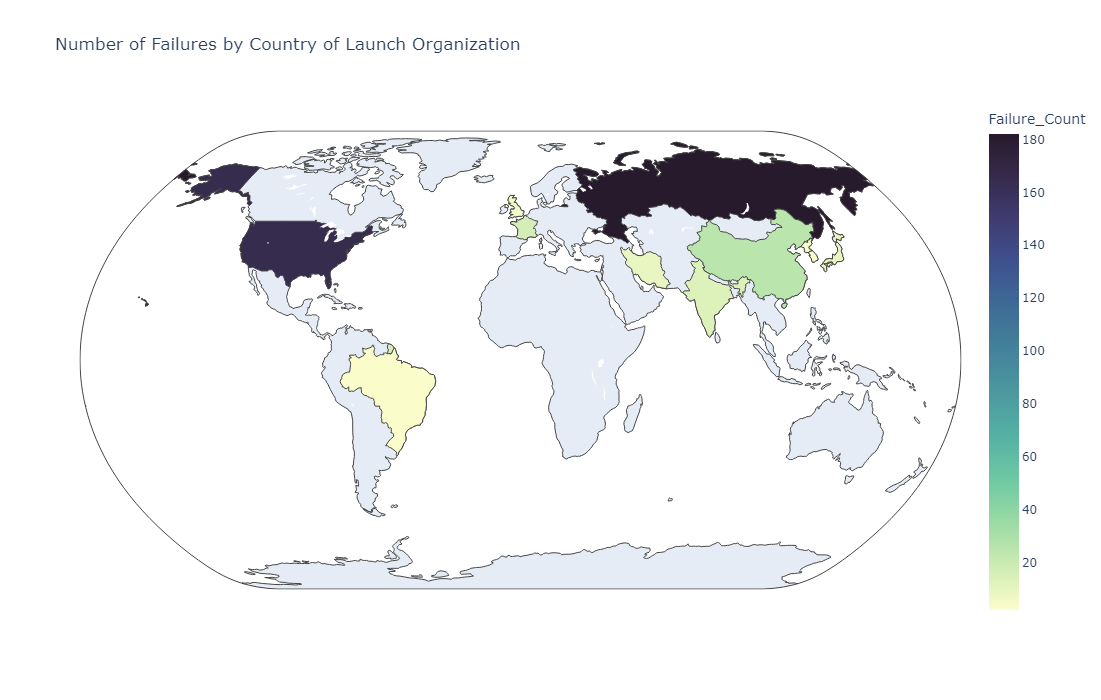

In [66]:
fail_mission_country = px.choropleth(failure_counts, locations="ISO_org_country", 
                                     color='Failure_Count', 
                                     hover_name="Organization_Country", 
                                     projection='natural earth',
                                     color_continuous_scale=px.colors.sequential.deep,
                                     title='Number of Failures by Country of Launch Organization',
                                     )


fail_mission_country.update_layout(height=700, width = 1000)
fail_mission_country.show()

In [67]:
%%html
<div>
    <img src="assets/fail_mission_country.png"/>
</div>

### Sunburst Chart of the countries, organisations, and mission status. 

In [68]:
country_org_status = clean_df.groupby(by=['Organization_Country', 
                                          'Organisation', 
                                          'Mission_Status'], as_index=False).agg({'Date': pd.Series.count})

country_org_status = country_org_status.sort_values('Date', ascending=False)

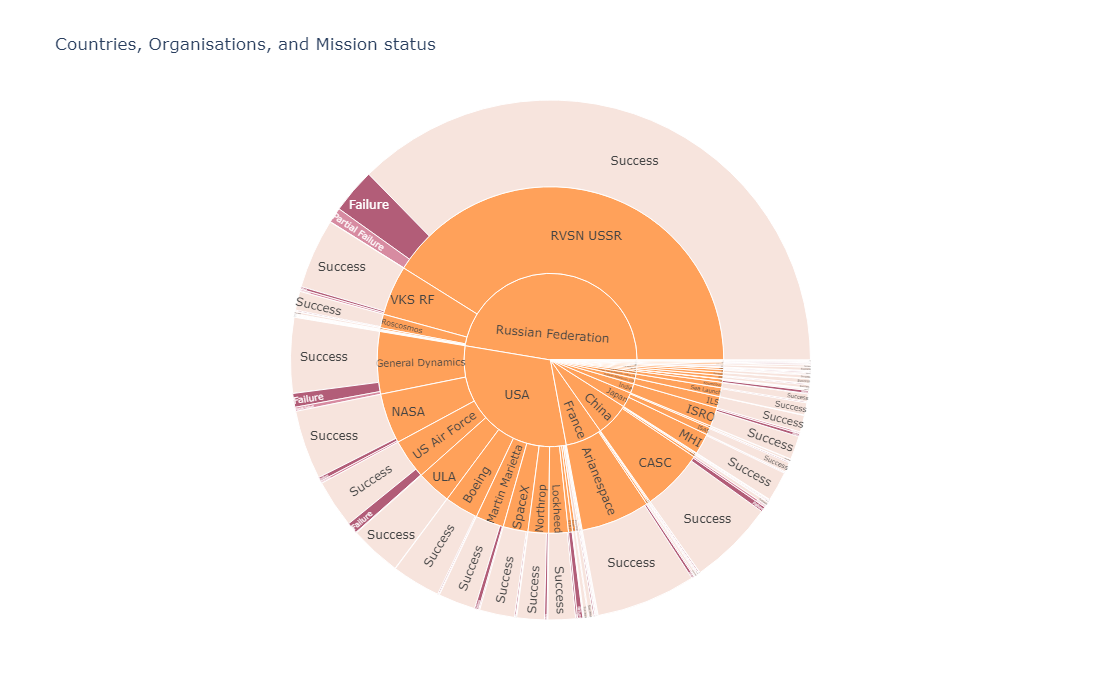

In [69]:
burst = px.sunburst(country_org_status, 
                    path=['Organization_Country', 'Organisation', 'Mission_Status'], 
                    values='Date',
                    title='Countries, Organisations, and Mission status',
                    color='Mission_Status',
                    color_discrete_map = {"Success": "#F4D9D0", "Failure" : "#921A40", "Partial Failure": "#C75B7A", "Prelaunch Failure": "#D9ABAB"},
                    # color='Date',
                    # color_continuous_scale='dense',
                    hover_data=['Organization_Country','Organisation', 'Mission_Status', 'Date'])

burst.update_layout(xaxis_title='Mission status', 
                    yaxis_title='City',
                    coloraxis_showscale=False,
                    height=700,
                    width = 1100)
burst.show()

In [70]:
%%html
<div>
    <img src="assets/burst.png"/>
</div>

### Total Amount of Money Spent by Organisation on Space Missions

In [71]:
# Find launches with not null price
not_null_price = clean_df.loc[clean_df['Price'].notnull() & (clean_df['Price'] != 0)]

In [72]:
organisation_spent = not_null_price.groupby(by=['Organisation'], as_index=False).agg({'Price': 'sum'}).sort_values('Price',  ascending=True)

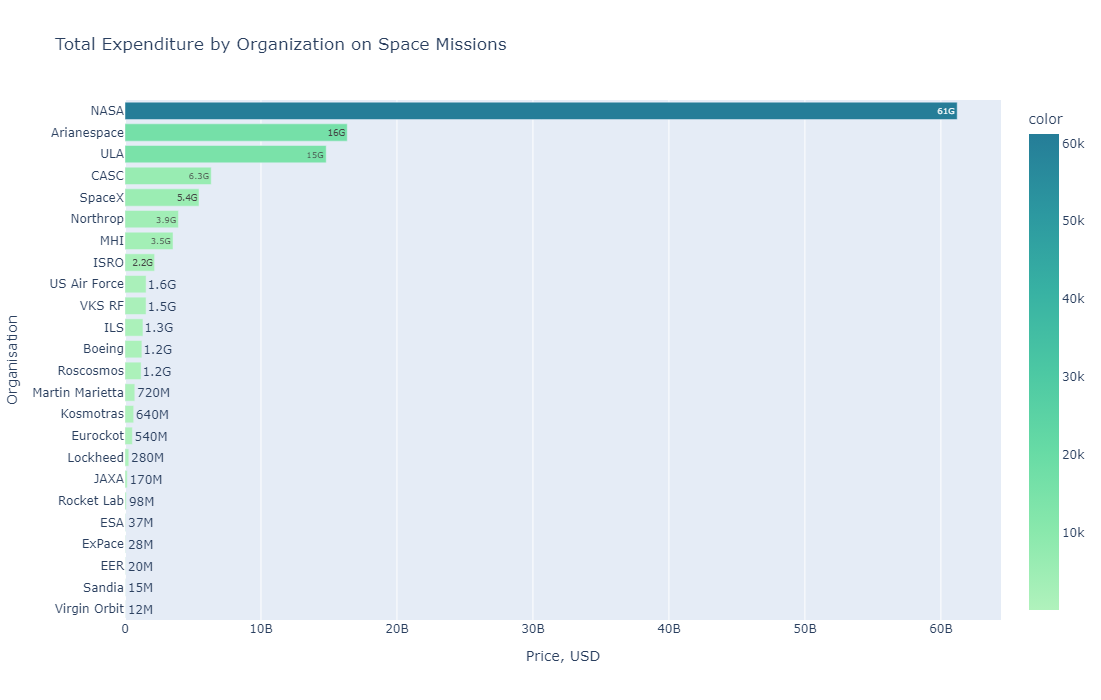

In [73]:
total_expend = px.bar(x = organisation_spent.Price*1000000,
               y = organisation_spent.Organisation,
               orientation='h',
               title="Total Expenditure by Organization on Space Missions",
               text_auto='.2s',
               height = 700,
               color= organisation_spent.Price, color_continuous_scale=px.colors.sequential.Tealgrn)

total_expend.update_layout(xaxis_title='Price, USD', yaxis_title='Organisation')
total_expend.show()

In [74]:
%%html
<div>
    <img src="assets/total_expend.png"/>
</div>

**The data on mission prices is incomplete, with only 964 out of 4,324 values available, as previously noted in the descriptive statistics. Therefore, our analysis is limited to the information provided by 12 companies**

### Amount of Money Spent by Organisation per Launch

In [75]:
not_null_price.loc[:, "Price"] = not_null_price["Price"]
mean_price_per_launch = not_null_price.groupby(["Organisation"],  as_index=False).agg({'Price': 'mean'}).sort_values('Price',  ascending=True)

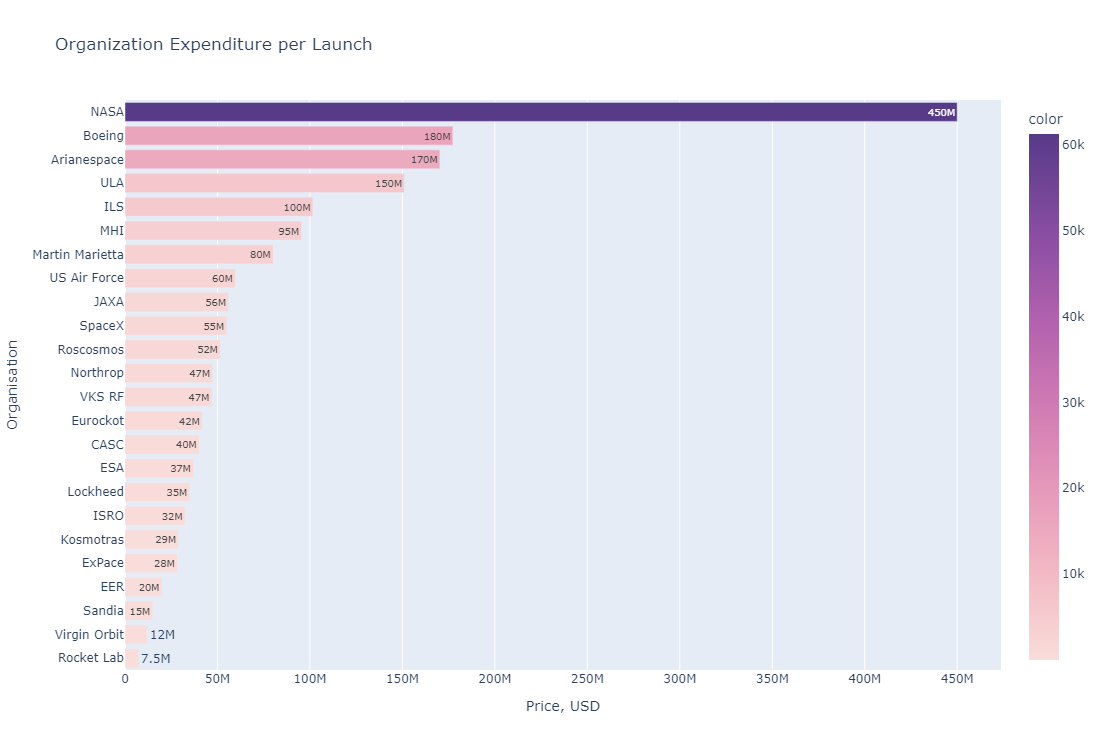

In [76]:
price_per_launch = px.bar(x = mean_price_per_launch.Price*1000000,
               y = mean_price_per_launch.Organisation,
               orientation='h',
               title="Organization Expenditure per Launch",
               text_auto='.2s',
               height = 750,
               color= organisation_spent.Price, color_continuous_scale=px.colors.sequential.Purpor)

price_per_launch.update_layout(xaxis_title='Price, USD', yaxis_title='Organisation')
price_per_launch.show()

In [77]:
%%html
<div>
    <img src="assets/price_per_launch.png"/>
</div>

### Chart the Number of Launches per Year

In [78]:
launches_per_year = clean_df['Year'].value_counts().sort_index(ascending=True)

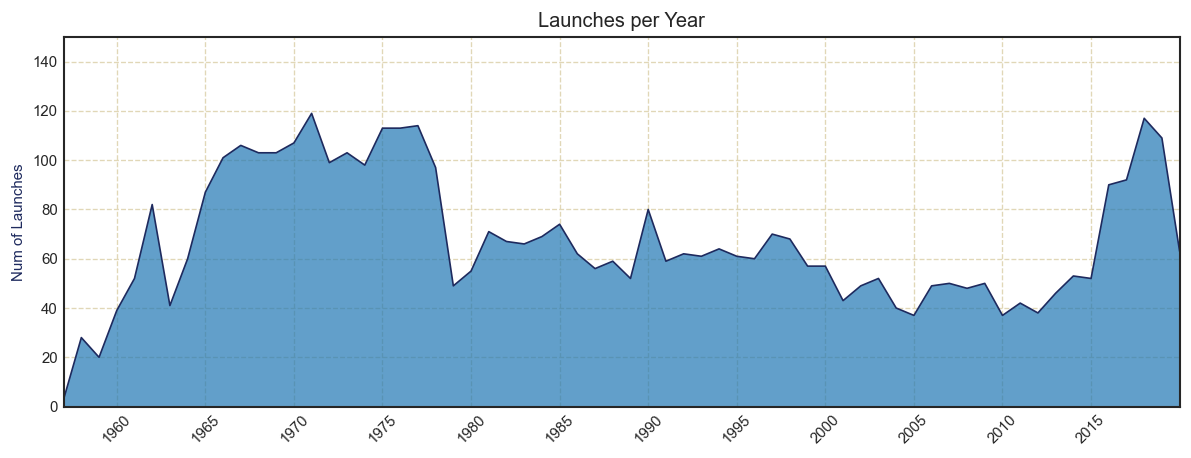

In [79]:
plt.figure(figsize=(12,4), dpi=120)

plt.title('Launches per Year', fontsize=12)
plt.xticks(ticks=np.arange(1960, 2020, step=5), fontsize=9, rotation=45)
plt.yticks(fontsize=9)

ax1 = plt.gca()
ax1.set_ylabel('Num of Launches', color='#1E2A5E', fontsize=9)
ax1.set_ylim(bottom=0, top=150)
ax1.set_xlim([launches_per_year.index.min(), launches_per_year.index.max()])
ax1.grid(color='#E1D7B7', linestyle='--')
ax1.fill_between(launches_per_year.index, 0, launches_per_year.values, alpha=0.7)

# Plot
ax1.plot(launches_per_year.index, launches_per_year.values, 
          color='#1E2A5E', linewidth=1, linestyle='-')

plt.show()

### Number of Launches Month-on-Month until the Present

Which month has seen the highest number of launches in all time? Superimpose a rolling average on the month on month time series chart. 

In [80]:
# Create df with data and amount of launches
launches_per_date = clean_df.Date.value_counts()
launches_per_date = pd.DataFrame({"date" : launches_per_date.index,
                                 "launches" : launches_per_date.values})

In [81]:
# Find launches per month
launches_per_month = launches_per_date.resample('ME', on='date').sum()
launches_per_month = launches_per_month.reset_index()
launches_per_month.rename(columns={'index': 'date'}, inplace=True)

In [82]:
# Find the max number of launches
max_launches = launches_per_month['launches'].max()
max_launches_row = launches_per_month.loc[launches_per_month['launches'] == max_launches]

# Print the statement with the highest number of launches, month, and year
print(f"The largest number of launches in all time was {max_launches} in {max_launches_row.date.dt.month.values[0]}/{max_launches_row.date.dt.year.values[0]}.")

The largest number of launches in all time was 18 in 12/1971.


*Graph creation*

In [83]:
# To smooth graph line - count 6 months rolling average of the number of launches
roll_launches_per_month = launches_per_month["launches"].rolling(window=6).mean()
roll_launches_per_month

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
750   9.67
751   9.17
752   7.67
753   8.67
754   7.67
Name: launches, Length: 755, dtype: float64

In [84]:
# Create locators for ticks on the time axis
years = mdates.YearLocator()
months = mdates.MonthLocator()
years_fmt = mdates.DateFormatter("%Y")

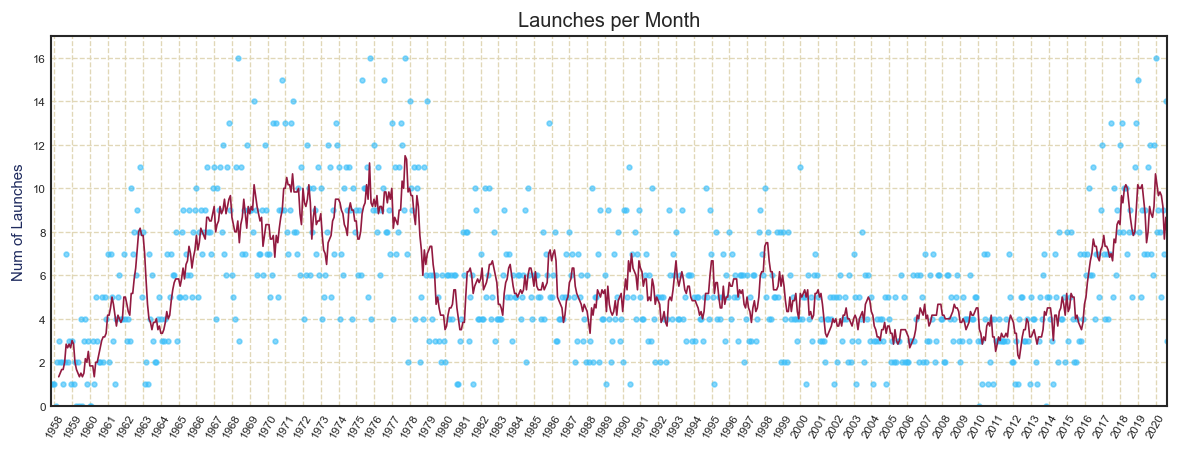

In [85]:
# Create plot + scatter plot
plt.figure(figsize=(12,4), dpi=120)

plt.title('Launches per Month', fontsize=12)
plt.xticks(ticks=np.arange(1958, 2020, step=5), fontsize=7, rotation=60)
plt.yticks(fontsize=7)

ax1 = plt.gca()
ax1.set_ylabel('Num of Launches', color='#1E2A5E', fontsize=9)
ax1.set_ylim(bottom=0, top=17)
ax1.set_xlim([launches_per_month.date.min(), launches_per_month.date.max()])
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)
ax1.xaxis.set_minor_locator(months)
ax1.grid(color='#E1D7B7', linestyle='--')

# Plot (6 months rolling average of the number of launches)
ax1.plot(launches_per_month.date, 
         roll_launches_per_month.values, 
         color='#921A40', linewidth=1, linestyle='-')

# Scatter plot
ax1.scatter(x=launches_per_month.date,
            y=launches_per_month.launches,
            c='#3ABEF9',
            alpha=0.6,
            s=8)

plt.show()

### Launches per Month: Which months are most popular and least popular for launches?

Some months have better weather than others. Which time of year seems to be best for space missions?

In [86]:
# Create 'month' column
launches_per_month["month"] = launches_per_month.date.dt.month
launches_per_month['month'] = pd.to_datetime(launches_per_month['month'], format='%m').dt.strftime('%B')

In [87]:
# Find sum of launches by month
sum_month_launches = (launches_per_month
                      .groupby(['month'], as_index=False)
                      .agg({"launches": "sum"})
                      .sort_values('launches', ascending=False))

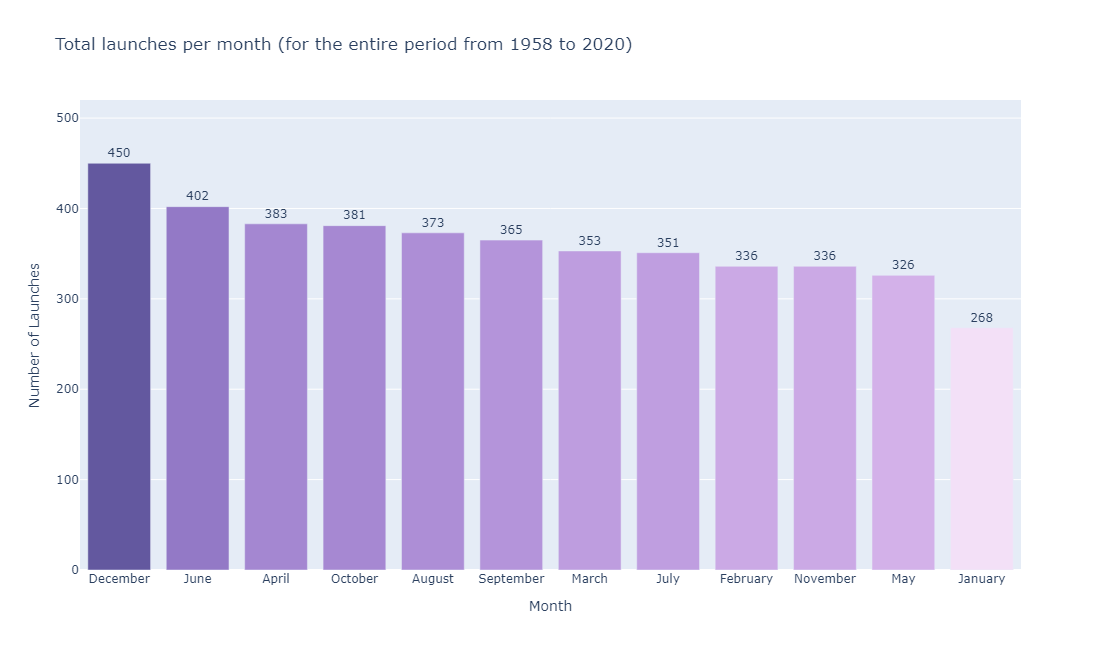

In [88]:
month_launches = px.bar(
    sum_month_launches,  
    x='month',  
    y='launches',
    color='launches',
    color_continuous_scale="Purp",
    title="Total launches per month (for the entire period from 1958 to 2020)",
    height=650,
    text='launches',
)

month_launches.update_layout(
    coloraxis_showscale=False,
    yaxis_title='Number of Launches',
    xaxis_title='Month',
    bargap=0.2,
    showlegend=False
)

month_launches.update_traces(textposition='outside')
month_launches.update_yaxes(range=[0, 520])
month_launches.show()

In [89]:
%%html
<div>
    <img src="assets/month_launches.png"/>
</div>

**The analysis indicates that the most favorable weather conditions for launches occur in December, June, and April, while the least favorable conditions are observed in May and January.**


### Change in Launch Price over Time


In [90]:
# Filter df on 0 prices and count avg price 
filtered_df = clean_df[clean_df["Price"] > 0]
avg_launch_price_by_year = filtered_df.groupby(["Year"])["Price"].mean()

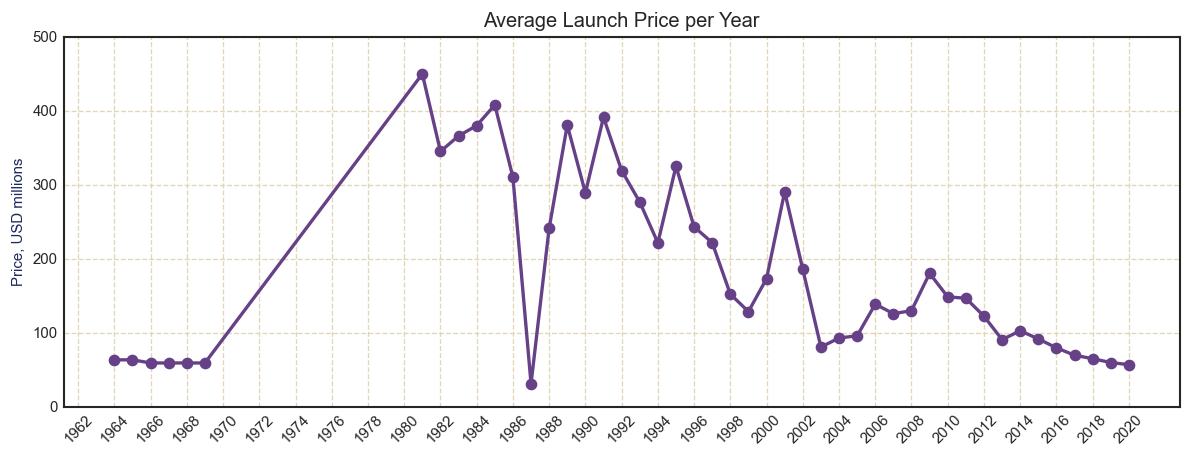

In [91]:
plt.figure(figsize=(12,4), dpi=120)

plt.title('Average Launch Price per Year', fontsize=12)
plt.xticks(ticks=np.arange(1958, 2021, step=2), fontsize=9, rotation=45)
plt.yticks(fontsize=9)


ax1 = plt.gca()
ax1.set_ylim(bottom=0, top=500)
ax1.set_ylabel('Price, USD millions', color='#1E2A5E', fontsize=9)
ax1.grid(color='#E1D7B7', linestyle='--')

ax1.plot(avg_launch_price_by_year.index, 
         avg_launch_price_by_year.values, 
         color='#674188', linewidth=2, linestyle='-',
         marker='o')


plt.show()

### Number of Launches over Time by the Top 10 Organisations. 

How has the dominance of launches changed over time between the different players? 

In [92]:
# extract top 10 organisations from previous series
mission_by_organisation.index

NameError: name 'mission_by_organisation' is not defined

In [ ]:
organizations = ['RVSN USSR', 'Arianespace', 'General Dynamics', 'CASC', 'NASA', 'VKS RF', 'US Air Force', 'ULA', 'Boeing', 'Martin Marietta']

In [ ]:
filtered_df = clean_df[clean_df["Organisation"].isin(organizations)]

In [ ]:
top_10_org = filtered_df.groupby(["Year", "Organisation"], as_index=False).count()
top_10_org = top_10_org[['Mission_Status',"Year", "Organisation"]].sort_values('Year', ascending=True)

In [ ]:
# Create a series that has the cumulative sum for the number of launches.

cumulative_launches = top_10_org.groupby(by=["Year", "Organisation"]).sum().groupby(level=[1]).cumsum()
cumulative_launches.reset_index(inplace=True)

In [ ]:
plt.figure(figsize=(14, 6)) 
plt.title('Year by Year Number of Launches of Top 10 Organisations', fontsize=12)
plt.xticks(ticks=np.arange(1960, 2021, step=5), fontsize=11, rotation=45)
plt.yticks(fontsize=11)
plt.ylabel("Number of Launches")

sns.lineplot(data=top_10_org , 
             x="Year", 
             y='Mission_Status',
             hue="Organisation",
             legend = "auto",
             linewidth = 2.5)
sns.set_style("whitegrid")

plt.show()

In [ ]:
plt.figure(figsize=(14, 6)) 
plt.title('Cumulative Sum of Launches for the Top 10 Organisations', fontsize=12)
plt.xticks(ticks=np.arange(1960, 2021, step=5), fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.ylabel("Number of Launches")

sns.lineplot(data=cumulative_launches, 
             x="Year", 
             y='Mission_Status',
             hue="Organisation",
             legend = "auto",
             linewidth = 2.5)


plt.show()

### Number of Launches over Time by the Top 10 Countries 

In [ ]:
top_10_countries = organisation_related_country.index[:10]

In [ ]:
filtered_df = clean_df[clean_df["Organization_Country"].isin(top_10_countries)]

In [ ]:
top_10_countr = filtered_df.groupby(["Year", "Organisation", "Organization_Country"], as_index=False).count()

In [ ]:
# Create a series that has the cumulative sum for the number of launches.

cumulative_country_launches = top_10_countr.groupby(by=["Year", "Organisation", "Organization_Country"]).sum().groupby(level=[2]).cumsum()
cumulative_country_launches.reset_index(inplace=True)

In [ ]:
plt.figure(figsize=(14, 6)) 
plt.title('Cumulative Sum of Launches for the Top 10 Countries', fontsize=14)
plt.xticks(ticks=np.arange(1960, 2021, step=5), fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.ylabel("Number of Launches", fontsize=12)
ax1.set_ylim(bottom=0, top=2100)
ax1.set_xlim([1960, 2021])

cumulative_country_launch=sns.lineplot(data=cumulative_country_launches, 
                                         x="Year", 
                                         y='Mission_Status',
                                         hue="Organization_Country",
                                         legend = "auto",
                                         linewidth = 2.5)



In [ ]:
missions_by_org = filtered_df.groupby(["Organization_Country", "Organisation"], as_index=False).agg({'Mission_Status': pd.Series.count})
missions_by_org.sort_values('Mission_Status', inplace=True, ascending=False)
missions_by_country = filtered_df.groupby(["Organization_Country"], as_index=False).agg({'Mission_Status': pd.Series.count})
missions_by_country.sort_values('Mission_Status', inplace=True, ascending=False)
top10_country_org_launches = pd.merge(missions_by_org, missions_by_country, on="Organization_Country", suffixes=('_org', '_country_total'))
top10_country_org_launches.sort_values('Mission_Status_country_total', inplace=True, ascending=False)

In [ ]:
hover_columns = ['Organisation', 'Organization_Country', 'Mission_Status_org']


org_counrtry_bar = px.bar(top10_country_org_launches,
                          x='Mission_Status_org',
                          y='Organization_Country',
                          color='Organisation',
                          orientation='h',
                          title='Top 10 Countries by Launch Count and Organization Distribution',
                          custom_data=hover_columns, 
)

org_counrtry_bar.update_layout(xaxis_title='Number of Launches',
                               yaxis_title='Country',
                               height=800,  
                               width=1100   
)

hover_template = '<b>%{customdata[0]}</b> <br>' \
                 '<b>Country:</b> %{customdata[1]}<br>' \
                 '<b>Number of Launches:</b> %{customdata[2]}<extra></extra>'

org_counrtry_bar.update_traces(hovertemplate=hover_template)
org_counrtry_bar.update_yaxes(autorange="reversed")

org_counrtry_bar.show()

In [ ]:
%%html
<div>
    <img src="assets/org_counrtry_bar.png"/>
</div>

# Cold War Space Race: USA vs USSR

The cold war lasted from the start of the dataset up until 1991. 

In [ ]:
cold_war = clean_df.loc[(clean_df.Year < 1992) & (clean_df.Organization_Country.isin(["USA", "Russian Federation"]))]

## Total number of launches of the USSR and the USA


In [ ]:
launch_num = cold_war.groupby("Organization_Country")['Mission_Status'].count()
launch_num

In [ ]:
color_map_status = {
    'Russian Federation': '#55679C',
    'USA': '#E1D7B7'
}

ussr_usa_launches = px.pie(
    values=launch_num.values,
    title='Total number of launches of the USSR and the USA',
    hole=0.2,
    names= ["USSR", "USA"],
    color = launch_num.index,
    color_discrete_map=color_map_status,
    width=600,  
    height=600   
)

ussr_usa_launches.update_traces(
    textinfo='label+percent+value', 
    textposition='inside'
)


ussr_usa_launches.update_layout(
    uniformtext_minsize=14,
    showlegend=False)

ussr_usa_launches.show()

In [ ]:
%%html
<div>
    <img src="assets/ussr_usa_launches.png"/>
</div>

## Total Number of Launches Year-On-Year by the Two Superpowers

In [ ]:
num_year_launches = cold_war.groupby(["Year", "Organization_Country"], as_index=False).agg({"Mission_Status": pd.Series.count})


In [ ]:
cold_war_total_year_launch = px.line(num_year_launches, x="Year", y='Mission_Status', color="Organization_Country",
              title='Total Number of Launches Year-On-Year',
              markers=True)

cold_war_total_year_launch.update_layout(xaxis_title='Year', yaxis_title='Number of Launches', legend_title_text='', width=1100, height=500)
cold_war_total_year_launch.for_each_trace(lambda t: t.update(name={'Russian Federation': 'USSR','USA': "USA"}[t.name]))
cold_war_total_year_launch.show()

In [ ]:
%%html
<div>
    <img src="assets/cold_war_total_year_launch.png"/>
</div>

## Total Number of Mission Failures Year on Year

In [ ]:
num_fail_launches = cold_war.loc[cold_war.Mission_Status.isin(["Failure", "Partial Failure", "Prelaunch Failure"])]
num_fail_launches = num_fail_launches.groupby(["Year", "Organization_Country"], as_index=False).agg({"Mission_Status": pd.Series.count})

In [ ]:
cold_war_total_year_fails = px.line(num_fail_launches, x="Year", y='Mission_Status', color="Organization_Country",
              title='Total Number of Mission Failures Year-On-Year',
              markers=True)

cold_war_total_year_fails.update_layout(xaxis_title='Year', yaxis_title='Mission Failures', legend_title_text='', width=1100, height=500)
cold_war_total_year_fails.for_each_trace(lambda t: t.update(name={'Russian Federation': 'USSR','USA': "USA"}[t.name]))
cold_war_total_year_fails.show()

In [ ]:
%%html
<div>
    <img src="assets/cold_war_total_year_fails.png"/>
</div>

In [ ]:
custom_palette = {'RVSN USSR': '#000099', 'US Navy' : "#ff0000", 'NASA': "#00ff00", 'US Air Force': "#ff66cc", 'General Dynamics': "#ff9933",
       'Martin Marietta': "#009933" , 'UT': "#4A646C", 'OKB-586': "#1B1B1B", 'Yuzhmash': "#cc3300", 'Roscosmos': "#5DADEC",
       'Boeing':"#9C51B6", 'Douglas': "#BFAFB2", 'Lockheed':"#FFF700", 'Northrop':"#0099cc"}

cold_war_catplot_mission_status = sns.catplot(data=cold_war, x="Year", y="Mission_Status", hue="Organisation",
                                     palette=custom_palette,
                                     height=6, 
                                     aspect=1.5, 
                                     kind="strip",
                                     size=9)
cold_war_catplot_mission_status.fig.suptitle("Mission Status Distribution Across Organizations", y=1.05)

In [ ]:
%%html
<div>
    <img src="assets/cold_war_catplot_fails.png"/>
</div>

### Total Number of Successful Launches 

Do the results change if we only look at the number of successful launches? 

In [ ]:
num_succ_launches = cold_war.loc[cold_war.Mission_Status == "Success"]
num_succ_launches = num_succ_launches.groupby(["Year", "Organization_Country"], as_index=False).agg({"Mission_Status": pd.Series.count})

In [ ]:
cold_war_succ_launch = px.line(num_succ_launches, x="Year", y='Mission_Status', color="Organization_Country",
              title='Total Number of Successful Launches Year-On-Year',
              markers=True)

cold_war_succ_launch.update_layout(xaxis_title='Year', yaxis_title='Mission Success', legend_title_text='', width=1100, height=500)
cold_war_succ_launch.for_each_trace(lambda t: t.update(name={'Russian Federation': 'USSR','USA': "USA"}[t.name]))
cold_war_succ_launch.show()

In [ ]:
%%html
<div>
    <img src="assets/cold_war_succ_launch.png"/>
</div>

### Organisation Doing the Most Number of Launches

Which organisation was dominant in the 1970s and 1980s? Which organisation was dominant in 2018, 2019 and 2020? 

In [ ]:
launch_organisation = cold_war.groupby(["Year", "Organisation"], as_index=False).agg({"Mission_Status": pd.Series.count})

In [ ]:
launch_organisation["Organisation"].unique()

In [ ]:
custom_palette = {'RVSN USSR': '#000099', 'US Navy' : "#ff0000", 'NASA': "#00ff00", 'US Air Force': "#ff66cc", 'General Dynamics': "#ff9933",
       'Martin Marietta': "#009933" , 'UT': "#4A646C", 'OKB-586': "#1B1B1B", 'Yuzhmash': "#cc3300", 'Roscosmos': "#5DADEC",
       'Boeing':"#9C51B6", 'Douglas': "#BFAFB2", 'Lockheed':"#FFF700", 'Northrop':"#0099cc"}

org_launch_num_cold_war = sns.catplot(data=launch_organisation, x="Year", y="Mission_Status", hue="Organisation",
                       palette=custom_palette, 
                       height=6, 
                       aspect=1.5, 
                       kind="strip",
                       size=9)

org_launch_num_cold_war.set_xticklabels(rotation=45)
org_launch_num_cold_war.set_axis_labels("", "Number of Launches")
org_launch_num_cold_war.ax.grid(True) 


In [ ]:
%%html
<div>
    <img src="assets/org_launch_num_cold_war.png"/>
</div>